# Vanilla auto encoder for feture extraction

### Attepmt to train the AutoEncoder (AE) as a feture extractor and improve for better classification 

**Overview** 
1. Undersample the class 8 to concner the inbalanced dataset
2. Train AutoEncoder with 7.5k training data with out label (Self-supervised)
3. Train liner classifier with 1.3k of training data with label (Which was not used in the AutoEncoder Training)
4. Validate trained liner classifier with 500 validation data

## GPUs information

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 24 10:14:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install required libraly

In [2]:
!pip install -q tfds-nightly tensorflow-datasets tensorflow matplotlib

     |████████████████████████████████| 4.0 MB 8.2 MB/s 


In [3]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import misc

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization,Flatten, Reshape
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [4]:
ds = tfds.load('deep_weeds', batch_size = -1, as_supervised = True)

images, labels = ds['train']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Shuffling deep_weeds-train.tfrecord...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Dataset deep_weeds downloaded and prepared to /root/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.


## Undersample class 8 to avoid overfitting 

In [5]:
img_0 = tf.gather_nd(images, tf.where(labels == 0)).numpy()
img_1 = tf.gather_nd(images, tf.where(labels == 1)).numpy()
img_2 = tf.gather_nd(images, tf.where(labels == 2)).numpy()
img_3 = tf.gather_nd(images, tf.where(labels == 3)).numpy()
img_4 = tf.gather_nd(images, tf.where(labels == 4)).numpy()
img_5 = tf.gather_nd(images, tf.where(labels == 5)).numpy()
img_6 = tf.gather_nd(images, tf.where(labels == 6)).numpy()
img_7 = tf.gather_nd(images, tf.where(labels == 7)).numpy()
img_8 = tf.gather_nd(images, tf.where(labels == 8)).numpy()


label_0 = tf.gather_nd(labels, tf.where(labels == 0)).numpy()
label_1 = tf.gather_nd(labels, tf.where(labels == 1)).numpy()
label_2 = tf.gather_nd(labels, tf.where(labels == 2)).numpy()
label_3 = tf.gather_nd(labels, tf.where(labels == 3)).numpy()
label_4 = tf.gather_nd(labels, tf.where(labels == 4)).numpy()
label_5 = tf.gather_nd(labels, tf.where(labels == 5)).numpy()
label_6 = tf.gather_nd(labels, tf.where(labels == 6)).numpy()
label_7 = tf.gather_nd(labels, tf.where(labels == 7)).numpy()
label_8 = tf.gather_nd(labels, tf.where(labels == 8)).numpy()

img_sorted = [img_0, img_1, img_2, img_3, img_4, img_5, img_6, img_7, img_8]
label_sorted = [label_0, label_1, label_2, label_3, label_4, label_5, label_6, label_7, label_8]

In [6]:
print(img_0.shape)
print(img_1.shape)
print(img_2.shape)
print(img_3.shape)
print(img_4.shape)
print(img_5.shape)
print(img_6.shape)
print(img_7.shape)
print(img_8.shape)

(1125, 256, 256, 3)
(1064, 256, 256, 3)
(1031, 256, 256, 3)
(1022, 256, 256, 3)
(1062, 256, 256, 3)
(1009, 256, 256, 3)
(1074, 256, 256, 3)
(1016, 256, 256, 3)
(9106, 256, 256, 3)


In [8]:
new_img = []
new_label = []

count = 0
for img, label in zip(img_8, label_8):
  if(count >= 1000):
    break
  new_img.append(img)
  new_label.append(label)
  count += 1

new_img = np.array(new_img)
new_label = np.array(new_label)

print(new_img.shape)
print(new_label.shape)

(1000, 256, 256, 3)
(1000,)


In [9]:
concated_image = np.concatenate((img_0, img_1, img_2, img_3, img_4, img_5, img_6, img_7, new_img), axis=0)

In [10]:
concated_label = np.concatenate((label_0, label_1, label_2, label_3, label_4, label_5, label_6, label_7, new_label), axis=0)

In [11]:
concated_image.shape

(9403, 256, 256, 3)

In [12]:
concated_label.shape

(9403,)

In [13]:
train_X, test_X, train_y, test_y = train_test_split(concated_image, concated_label, test_size=0.2, random_state=0)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(7522, 256, 256, 3)
(7522,)
(1881, 256, 256, 3)
(1881,)


In [14]:
X_train = []
Y_train = []

X_test = []
Y_test = []



for each_x, each_y in zip(train_X, train_y):
    X_train.append(each_x)
    Y_train.append(each_y)

for each_x, each_y in zip(test_X, test_y):
    X_test.append(each_x)    
    Y_test.append(each_y)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

(256, 256, 3)


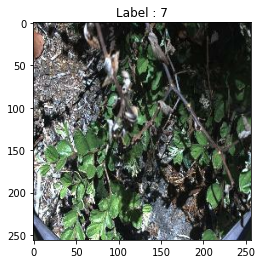

In [15]:
fig , ax = plt.subplots()
ax.imshow(X_train[3])
plt.title("Label : " + str(Y_test[0]))
print(X_train[0].shape)

In [16]:
print("X train shape" + str(X_train.shape))
print("X test shape" + str(X_test.shape))

X train shape(7522, 256, 256, 3)
X test shape(1881, 256, 256, 3)


## Buliding the autoencoder

In [17]:
# Encoder---
input_layer = Input(shape=(256, 256, 3), name="INPUT")

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

#Latent space (Comressed fetures)
code_layer = MaxPooling2D((2, 2), name="CODE")(x)

# Decoder----
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [18]:
weed_autoEncoder = Model(input_layer, output_layer)
weed_autoEncoder.compile(optimizer='adam', loss='mse')
weed_autoEncoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0     

## Train the decocder

In [19]:
weed_autoEncoder.fit(X_train, X_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
236/236 [==============================] - 31s 60ms/step - loss: 2795.4241 - val_loss: 2090.4856
Epoch 2/10
236/236 [==============================] - 13s 55ms/step - loss: 2033.2278 - val_loss: 1950.6334
Epoch 3/10
236/236 [==============================] - 13s 55ms/step - loss: 1947.9540 - val_loss: 1895.7289
Epoch 4/10
236/236 [==============================] - 13s 55ms/step - loss: 1902.7131 - val_loss: 1856.0554
Epoch 5/10
236/236 [==============================] - 13s 55ms/step - loss: 1870.4917 - val_loss: 1826.3605
Epoch 6/10
236/236 [==============================] - 13s 55ms/step - loss: 1837.0571 - val_loss: 1793.6044
Epoch 7/10
236/236 [==============================] - 13s 55ms/step - loss: 1805.7924 - val_loss: 1776.4172
Epoch 8/10
236/236 [==============================] - 13s 55ms/step - loss: 1792.7343 - val_loss: 1760.9714
Epoch 9/10
236/236 [==============================] - 13s 55ms/step - loss: 1783.7280 - val_loss: 1749.7295
Epoch 10/10
236/236 [=======

##Show encoded image

In [21]:
from tensorflow.keras.preprocessing import image

In [22]:
weed_Encoder = Model(inputs=weed_autoEncoder.input, outputs=weed_autoEncoder.get_layer("CODE").output)

In [23]:
encoded_weed_train = weed_Encoder.predict(X_train)

In [24]:
encoded_weed_train = encoded_weed_train.reshape((len(X_train), 32*32*8))
encoded_weed_train.shape

(7522, 8192)

In [25]:
encoded_weed_test = weed_Encoder.predict(X_test)
encoded_weed_test = encoded_weed_test.reshape((len(X_test), 32*32*8))
encoded_weed_test.shape

(1881, 8192)

In [26]:
reconstructed_weed = weed_autoEncoder.predict(X_test[:10])

In [27]:
def show_data(X, n=10, height=28, width=28, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].reshape((height,width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

In [28]:
def show_cat_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        plt.title("Label" + str(Y_test[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

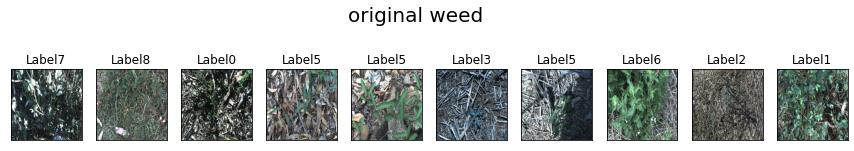

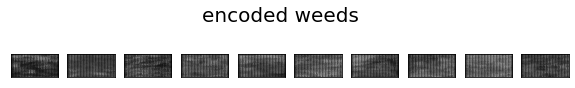

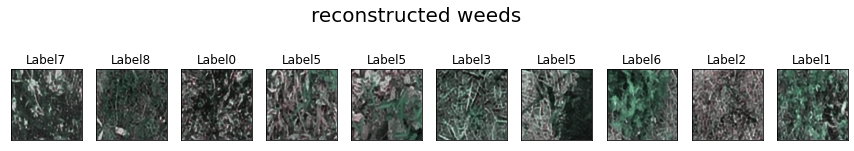

In [29]:
show_cat_data(X_test, title="original weed")
show_data(encoded_weed_test, height=64, width=128, title="encoded weeds")
show_cat_data(reconstructed_weed, title="reconstructed weeds")

## Train linner model for classificatoin

In [50]:
from sklearn.model_selection import train_test_split

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_test, Y_test, test_size=0.3, random_state=0)
print(X_train_new.shape)
print(y_train_new.shape)

print(X_test_new.shape)
print(y_test_new.shape)

(1316, 256, 256, 3)
(1316,)
(565, 256, 256, 3)
(565,)


In [51]:
X_train_new = weed_Encoder.predict(X_train_new)
X_test_new = weed_Encoder.predict(X_test_new)
print(X_train_new.shape)
print(y_train_new.shape)

print(X_test_new.shape)
print(y_test_new.shape)

(1316, 32, 32, 8)
(1316,)
(565, 32, 32, 8)
(565,)


In [62]:
train_image_vectors = tf.reshape(X_train_new, [-1,32*32*8]).numpy()
test_image_vectors = tf.reshape(X_test_new, [-1,32*32*8]).numpy()

print(train_image_vectors.shape)
print(y_train_new.shape)

print(test_image_vectors.shape)
print(y_test_new.shape)

(1316, 8192)
(1316,)
(565, 8192)
(565,)


In [63]:
from sklearn import  svm

new_clf = svm.SVC(gamma="scale")
svm_model = new_clf.fit(train_image_vectors, y_train_new)
print('svm accuracy for training set: %f' % svm_model.score(train_image_vectors, y_train_new))
print('svm accuracy for test set: %f' % svm_model.score(test_image_vectors, y_test_new))

svm accuracy for training set: 0.756079
svm accuracy for test set: 0.311504


In [64]:
from sklearn.metrics import classification_report

y_pred = svm_model.predict(test_image_vectors)

print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.51      0.39        68
           1       0.23      0.20      0.21        60
           2       0.32      0.65      0.43        51
           3       0.46      0.27      0.34        66
           4       0.29      0.23      0.26        64
           5       0.32      0.21      0.25        63
           6       0.30      0.52      0.38        62
           7       0.38      0.15      0.22        73
           8       0.23      0.12      0.16        58

    accuracy                           0.31       565
   macro avg       0.32      0.32      0.29       565
weighted avg       0.32      0.31      0.29       565

